<h3> Introduction/Business Problem </h3>
In the current competetive market of restuarants its not always a clean cut answer as to where the best place to open a restraunt is,

My proposal is that in order to better inform a restaurateur/ food franchise, I will leverage the Foursqaure data to determine the best way in which to find a suburb for a new store opening. In addition to this I will determine the most likely candidate for the 'type' of restraunt that could thrive in this suburb.

I believe this would better inform any persons or company looking to garner some insight as to where there are market gaps based on locations, 
possible increasing the liklihood of a restuarants success.

In [1]:
import pandas as pd
import requests
import numpy as np

from pandas.io.json import json_normalize

#install and add folium
!pip install folium --user
import folium

## Import Packages to get the Coords for each suburb
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install lxml
import lxml 

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

print("imported Packages")


     |████████████████████████████████| 122kB 5.5MB/s eta 0:00:01
     |████████████████████████████████| 5.5MB 21.6MB/s eta 0:00:01
Matplotlib version:  3.1.1
imported Packages


In [5]:
#url for suburb list
url5 = "http://geo.mycyberict.com/south_africa/johannesburg/"


table_suburbs = pd.read_html(url5)[1]
table_suburbs.columns=["Suburb","street","PO"]

table_suburbs['street']=table_suburbs['street'].astype(str)
table_suburbs['Suburb']=table_suburbs['Suburb'].astype(str)

#table_suburbs=table_suburbs[~table_suburbs.street.str.contains('n.a')]
#table_suburbs=table_suburbs[~table_suburbs.street.str.contains('N/a')]
#df_burbs=table_suburbs[~table_suburbs.street.str.contains('nan')]

#df_burbs

#table_suburbs = table_suburbs.drop_duplicates(subset=['street'])

print(table_suburbs.shape)
table_suburbs.head()


(1560, 3)


,Suburb,street,PO
0,nan,2000.0,2001.0
1,Abbotsford,nan,2192.0
2,Aeroton,2013.0,2190.0
3,Airdlin,2157.0,NaN
4,Alan Manor,nan,2091.0


In [6]:
#creat new dataframe headings and assigne to new DF
columnnames =['suburb','latitude','longitude']
df_burbloc = pd.DataFrame(columns=columnnames) 

#set column types
df_burbloc['suburb']=df_burbloc['suburb'].astype(str)
df_burbloc['latitude']=df_burbloc['latitude'].astype(float)
df_burbloc['longitude']=df_burbloc['longitude'].astype(float) 


#run for loop on suburb names, into geolocator, iterate through each and asign name, latitude and longitude to new DF
for burb in table_suburbs.Suburb:
    
    #try and exception loop to acount for error where geolocatr can find the co-ordinates
    try:
        
        city = " Johannesburg"
        address= burb + city
        
        #collect subrb info
        geolocator = Nominatim(user_agent="Capstone")
        location = geolocator.geocode(address)
        latitude = location.latitude    
        longitude = location.longitude

        #append info to datframe
        df_burbloc = df_burbloc.append({'suburb': burb,
                                        'latitude': latitude,
                                        'longitude': longitude},ignore_index=True )
        
        #print('The geograpical coordinate are {}, {}.'.format(latitude, longitude))
        
    except:        
        #try remove the spacing in the names and search for coords again
        try:
            city = ", Johannesburg"
            address= burb.replace(' ', '') + city
            
            #collect subrb info
            geolocator = Nominatim(user_agent="Capstone")
            location = geolocator.geocode(address)
            latitude = location.latitude    
            longitude = location.longitude

            #append info to datframe
            df_burbloc = df_burbloc.append({'suburb': burb,
                                            'latitude': latitude,
                                            'longitude': longitude},ignore_index=True )

            
        #in the event that the co-ords cant be found set them as Null/NaN values    
        except:
            
            latitude = None
            longitude = None
            df_burbloc = df_burbloc.append({'suburb': burb,
                                            'latitude': latitude,
                                            'longitude': longitude}, ignore_index=True)

            

In [7]:
#drop areas where the location is recorded as identical, this is a further cleaning of potentional 'Extensions'
df_sortedburbs = df_burbloc.drop_duplicates(subset=['latitude', 'longitude'])
df_sortedburbs = df_sortedburbs[df_sortedburbs['latitude'].notna()]


print(df_sortedburbs.shape)
df_sortedburbs = df_sortedburbs.reset_index(drop=True)
df_sortedburbs.head()


(291, 3)


,suburb,latitude,longitude
0,nan,-26.205000,28.049722
1,Abbotsford,-26.143177,28.068441
2,Aeroton,-26.254146,27.974187
3,Airdlin,-26.026460,28.060637
4,Alan Manor,-26.277691,27.992857


In [8]:
#MAP out Suburbs
city = " Johannesburg"

map_Jhb = folium.Map(location=[-26.195246, 28.034088], zoom_start=10)

# add markers to map
for lat, lng, suburb, in zip(df_sortedburbs['latitude'], df_sortedburbs['longitude'], df_sortedburbs['suburb']):
    label = '{}, {}'.format(suburb, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Jhb)  
    
map_Jhb

In [9]:
#in addition to the above Cleaning I am removing areas that form part of the south of the city, as its more industrious
df_sortedburbs = df_sortedburbs[~(df_sortedburbs['latitude'] <=-26.166239)]
df_sortedburbs = df_sortedburbs[~(df_sortedburbs['latitude'] >=0)]


In [10]:
#Plot suburbs to Map without southern suburbs
city = " Johannesburg"

map_Jhb = folium.Map(location=[-26.195246, 28.034088], zoom_start=10)

# add markers to map
for lat, lng, suburb, in zip(df_sortedburbs['latitude'], df_sortedburbs['longitude'], df_sortedburbs['suburb']):
    label = '{}, {}'.format(suburb, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Jhb)  
    
map_Jhb

In [11]:
# laod in foursqaure credentials

from pandas.io.json import json_normalize

CLIENT_ID = 'xxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxx' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HRCY1QHXDCF4RI3IMGADY2PWOPCTYC5D2PZY3MVY5HAA52I5
CLIENT_SECRET:2ZPA1TMY1ZAUHM1X0LDOG4NWBERR45OGMYMRLAMRGTOTO23G


In [16]:
# Get coords for all venues near suburb centre

#define the Getcategory function before we start the loop

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Create new Dataframe for all the venues before the loop
burb_venues= pd.DataFrame(columns=['Suburb','id','name','categories','lat','lng'])

#set max limit to iterate through
burbcount = df_sortedburbs.suburb.count()
print(burbcount)

#set starting count num
i = 1

#assign suburb value to variables for testing
while i <= burbcount:

    burb_lat = df_sortedburbs.loc[i, 'latitude'] # neighborhood latitude value
    burb_lng = df_sortedburbs.loc[i, 'longitude'] # neighborhood longitude value
    burb_name = df_sortedburbs.loc[i, 'suburb'] # neighborhood name


    #set Url Details
    LIMIT = 100
    radius = 2000 
    urlapi = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        burb_lat, 
        burb_lng, 
        radius,
        LIMIT)

    #get the Results of the url for venues near that suburb
    results = requests.get(urlapi).json()

     #get the venue details from the Json   
    venues = results['response']['groups'][0]['items']

    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues[filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

    #print(nearby_venues.shape)
    #nearby_venues.head()

    #add suburb name to data
    nearby_venues.insert(0,"Suburb",burb_name)

    #add the results of this suburb venue search the dataframe made to hodl all the info
    burb_venues= pd.concat([burb_venues,nearby_venues],axis=0)
    
    i = i +1

125


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


(37, 5)
(18, 5)
(14, 5)
(100, 5)
(100, 5)
(100, 5)
(35, 5)
(36, 5)
(22, 5)
(100, 5)
(91, 5)
(62, 5)
(15, 5)
(32, 5)
(42, 5)
(63, 5)
(19, 5)
(32, 5)
(59, 5)
(41, 5)
(52, 5)
(44, 5)
(6, 5)
(54, 5)
(95, 5)
(58, 5)
(69, 5)
(100, 5)
(62, 5)
(62, 5)
(5, 5)
(27, 5)
(29, 5)
(27, 5)
(11, 5)
(84, 5)
(56, 5)
(20, 5)
(93, 5)
(25, 5)
(8, 5)
(100, 5)
(77, 5)
(17, 5)
(48, 5)
(38, 5)
(100, 5)
(100, 5)
(100, 5)
(56, 5)
(51, 5)
(38, 5)
(29, 5)
(15, 5)
(12, 5)
(6, 5)
(71, 5)
(15, 5)
(14, 5)
(59, 5)
(59, 5)
(21, 5)
(26, 5)
(45, 5)
(85, 5)
(86, 5)
(25, 5)
(64, 5)
(51, 5)
(34, 5)
(70, 5)
(73, 5)
(20, 5)
(43, 5)
(45, 5)
(72, 5)
(25, 5)
(35, 5)
(46, 5)
(100, 5)
(100, 5)
(35, 5)
(100, 5)
(39, 5)
(100, 5)
(39, 5)
(74, 5)
(32, 5)
(17, 5)
(49, 5)
(45, 5)
(28, 5)
(45, 5)
(100, 5)
(47, 5)
(76, 5)
(86, 5)
(47, 5)
(38, 5)
(50, 5)
(35, 5)
(48, 5)
(83, 5)
(18, 5)
(69, 5)
(100, 5)
(28, 5)
(52, 5)
(58, 5)
(26, 5)
(67, 5)
(27, 5)
(13, 5)
(49, 5)
(48, 5)
(21, 5)
(28, 5)
(88, 5)
(27, 5)
(76, 5)
(99, 5)
(53, 5)
(24, 5)
(38, 

KeyError: 125

In [19]:
burb_venues = burb_venues.reset_index(drop = True) 
print(burb_venues.shape)
burb_venues.head()

NameError: name 'burb_venues' is not defined

In [21]:
#Save List To CSV for later use, avoiding having to rerun all
burb_venues.to_csv('burb venue list all 2km rad.csv',index=False)
print(burb_venues.shape)


(6298, 6)


<h1><b> ------------------------Save Point--------------------------------- </b></h1>
the above code results in a save file that will allow for resuming starting from below without having to recalc everything

In [2]:
#Read Csv for easy resume
    burb_venues2 = pd.read_csv('burb venue list all.csv')
    print(burb_venues2.shape)
    burb_venues2.head()

(6298, 6)


,Suburb,id,name,categories,lat,lng
0,Airdlin,4d9eeffd8ef3a14381c98610,Chilli Lane Shopping Centre,Shopping Mall,-26.029047,28.060680
1,Airdlin,4bcef2faef10952132ce8486,Pick n Pay,Supermarket,-26.028899,28.060220
2,Airdlin,4f75f43ce4b04e9a8acedf4d,The Barnyard Theatre Rivonia,Theater,-26.036174,28.059470
3,Airdlin,4bcef1a8b6c49c7442da9791,Woolworths,Supermarket,-26.029731,28.060490
4,Airdlin,4d8f0e2afa943704bfa211c6,Taste Of Punjab,Indian Restaurant,-26.025672,28.066288


In [13]:
#set list of 'restraunt' type criteria for filtering
to_drop = ['Restaurant','Place','Joint','Steakhouse','Bistro']

cat_list=burb_venues2[burb_venues2.categories.str.contains('|'.join(to_drop))]

#drop areas where the location is recorded as identical, this is a further cleaning of potentional 'Extensions'
cat_list = cat_list.drop_duplicates(subset=['lat', 'lng'])


cat_list=cat_list.reset_index(drop = True)
print(cat_list.shape)
cat_list.head()

(584, 6)


,Suburb,id,name,categories,lat,lng
0,Airdlin,4d8f0e2afa943704bfa211c6,Taste Of Punjab,Indian Restaurant,-26.025672,28.066288
1,Airdlin,4b72fd39f964a5202b942de3,Thai cafe,Thai Restaurant,-26.035650,28.051035
2,Airdlin,4c382e512c8020a1e8708a00,Doppio Zero,Mediterranean Restaurant,-26.028806,28.060880
3,Airdlin,51dd8002498e219fc19ee6aa,Adega,Portuguese Restaurant,-26.036799,28.059402
4,Airdlin,52cd76a9498e326a06dd3fbb,Mexican Fresh,Mexican Restaurant,-26.028800,28.060900


In [14]:
#take venue occurence and plot it against unique types
df_freq = cat_list['categories'].value_counts().rename_axis('categories').to_frame('freq')
df_freq.head()

,freq
categories,
Italian Restaurant,72
Pizza Place,65
Restaurant,48
Fast Food Restaurant,47
Steakhouse,41


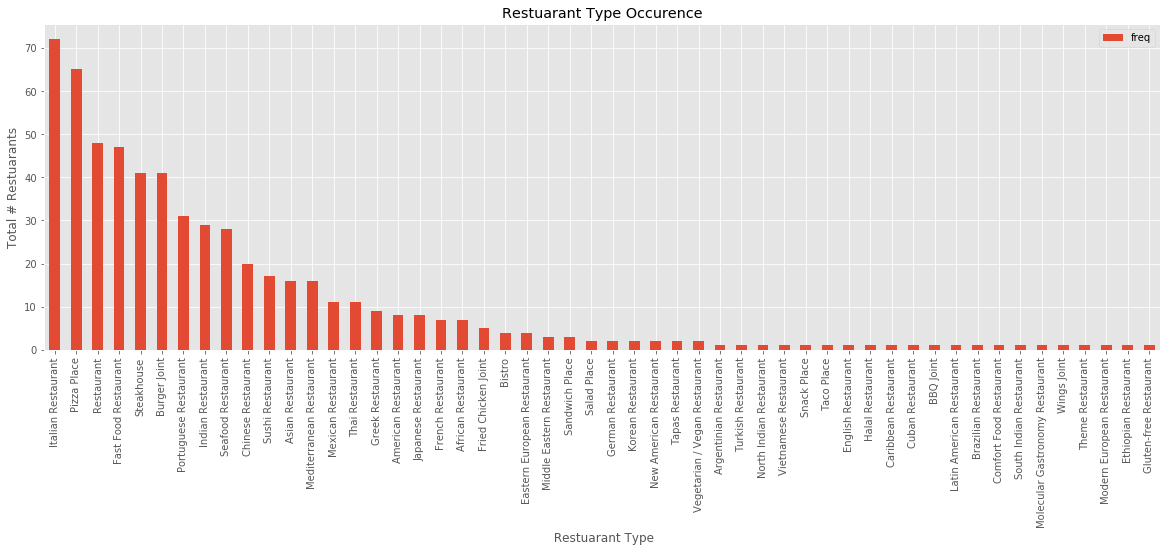

In [15]:
#plot graph showing the number of each type that appears in recorded suburbs

#change column to int
df_freq['freq'] = df_freq['freq'].astype(int)
#sort column highest to lowest
df_freq.sort_values(['freq'], ascending=False, axis=0, inplace=True)

#plot Graph
df_freq.plot(kind='bar', figsize=(20, 6))

plt.title ("Restuarant Type Occurence")
plt.ylabel ("Total # Restuarants")
plt.xlabel (" Restuarant Type")

plt.show()

In [6]:
cat_list.head()

,Suburb,id,name,categories,lat,lng
0,Airdlin,4d8f0e2afa943704bfa211c6,Taste Of Punjab,Indian Restaurant,-26.025672,28.066288
1,Airdlin,4b72fd39f964a5202b942de3,Thai cafe,Thai Restaurant,-26.035650,28.051035
2,Airdlin,4c382e512c8020a1e8708a00,Doppio Zero,Mediterranean Restaurant,-26.028806,28.060880
3,Airdlin,51dd8002498e219fc19ee6aa,Adega,Portuguese Restaurant,-26.036799,28.059402
4,Airdlin,52cd76a9498e326a06dd3fbb,Mexican Fresh,Mexican Restaurant,-26.028800,28.060900


In [9]:
# Get Rating for Restuarants

columnnames =['suburb','id','name','categories','lat','lng','rating']
df_ratedvenue = pd.DataFrame(columns=columnnames) 

#vencount = cat_list.Suburb.count()
#vencount = 505

i = 498

while i <=vencount:
       
    rate_ven = cat_list.loc[i, 'Suburb'] # neighborhood latitude value
    rate_id = cat_list.loc[i, 'id'] # neighborhood longitude value
    rate_name = cat_list.loc[i, 'name'] # neighborhood name
    rate_categories = cat_list.loc[i, 'categories'] # neighborhood longitude value
    rate_lat = cat_list.loc[i, 'lat'] # neighborhood name
    rate_lng = cat_list.loc[i, 'lng'] # neighborhood name
    ven_id = cat_list.loc[i, 'id']  # Venue id
    
    urlven = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            ven_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    rate = requests.get(urlven).json()
    
    try:
        venrate=rate['response']['venue']['rating']
        df_ratedvenue=df_ratedvenue.append({'suburb': rate_ven,
                                        'id': rate_id,
                                        'name': rate_name,
                                        'categories': rate_categories,
                                        'lat': rate_lat,
                                        'lng': rate_lng,
                                        'rating': venrate
                                       }, ignore_index=True)   
    except:      
      
        venrate= None
        df_ratedvenue=df_ratedvenue.append({'suburb': rate_ven,
                                        'id': rate_id,
                                        'name': rate_name,
                                        'categories': rate_categories,
                                        'lat': rate_lat,
                                        'lng': rate_lng,
                                        'rating': venrate
                                       }, ignore_index=True)    
    
    #print("rated:", venrate)   
    
    i=i+1
    

rated: 7.1
rated: 7.0
rated: 7.2
rated: 7.0
rated: 6.6
rated: 6.1
rated: None
rated: None
rated: None
rated: 8.2
rated: 7.9
rated: 6.7
rated: None
rated: 8.2
rated: 8.1
rated: 7.8
rated: 8.1
rated: 7.9
rated: 7.5
rated: 7.8
rated: 7.5
rated: 8.3
rated: 7.4
rated: 7.6
rated: 7.6
rated: 7.5
rated: 7.6
rated: 7.3
rated: 7.0
rated: 7.2
rated: 7.2
rated: 7.1
rated: 7.0
rated: 6.2
rated: 5.9
rated: 5.8
rated: None
rated: None
rated: 7.9
rated: 7.3
rated: 6.2
rated: 5.9
rated: None
rated: None
rated: None
rated: 5.6
rated: 7.2
rated: 7.1
rated: 6.6
rated: 5.8
rated: 5.7
rated: 6.1
rated: 7.6
rated: 5.9
rated: 7.5
rated: 8.5
rated: 8.0
rated: 7.8
rated: 7.7
rated: 8.7
rated: 7.5
rated: 7.2
rated: 6.9
rated: 6.6
rated: 6.3
rated: 6.6
rated: 6.1
rated: 5.9


KeyboardInterrupt: 

In [6]:
# one hot encoding
burb_tran = pd.get_dummies(cat_list[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
burb_tran['Suburb'] = cat_list['Suburb'] 

# move neighborhood column to the first column
fixed_columns = [burb_tran.columns[-1]] + list(burb_tran.columns[:-1])
burb_tran = burb_tran[fixed_columns]

burb_trangroup = burb_tran.groupby('Suburb').mean().reset_index()
burb_trangroup.head()

,Suburb,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bistro,Brazilian Restaurant,Burger Joint,Caribbean Restaurant,...,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Airdlin,0.000000,0.000000,0.0,0.111111,0.000000,0.0,0.0,0.055556,0.0,...,0.055556,0.000000,0.0,0.000000,0.055556,0.0,0.0,0.0,0.0,0.0
1,Albertskroon,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.250000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,Alexandra,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.500000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,Atholhurst,0.026316,0.026316,0.0,0.026316,0.026316,0.0,0.0,0.078947,0.0,...,0.131579,0.052632,0.0,0.026316,0.052632,0.0,0.0,0.0,0.0,0.0
4,Atholl,0.000000,0.000000,0.0,0.076923,0.000000,0.0,0.0,0.000000,0.0,...,0.153846,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


<H1> save POINT 2 </H1>

SAVING OF THE RATED LIST DUE TO LIMITS ON CALLS

In [3]:
# df_ratedvenue.to_csv('Venues Rated 1st 500-3.csv',index=False)
# print(df_ratedvenue.shape)

NameError: name 'df_ratedvenue' is not defined

In [3]:
#Read Csv for easy resume
    df_ratedvenue = pd.read_csv('Venues Rated All.csv')
    print(df_ratedvenue.shape)
    df_ratedvenue.tail()

(739, 7)


,suburb,id,name,categories,lat,lng,rating
734,Wynberg,4efee7655c5c51dd2d7f921e,Ekhaya chisa nyama,Steakhouse,-26.106667,28.085751,NaN
735,Wynberg,4c4c499546240f47ce7492f4,Giramundo Chicken,Fast Food Restaurant,-26.106458,28.089181,NaN
736,Zonneblom,4bd1feaf462cb713b55cdb07,Chaplin's Grill,Steakhouse,-26.090384,28.024404,8.5
737,Zonneblom,4c6aa96e2c29d13a994d0e41,Amici,Pizza Place,-26.089792,28.023790,NaN
738,Zonneblom,51af989d498e74c93b15aa2c,Steers,Fast Food Restaurant,-26.097467,28.031553,NaN


In [9]:
#MAP VENUES and suburbs to area map
map_ven = folium.Map(location=[-26.195246, 28.034088], zoom_start=10)
city = " Johannesburg"

# add markers to map
for lat, lng, suburb, in zip(df_ratedvenue['lat'], df_ratedvenue['lng'], df_ratedvenue['suburb']):
    label = '{}, {}'.format(suburb, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#F9820B',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ven)  
    
for lat, lng, suburb, in zip(df_sortedburbs['latitude'], df_sortedburbs['longitude'], df_sortedburbs['suburb']):
    label = '{}, {}'.format(suburb, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ven)     
    
map_ven

NameError: name 'df_sortedburbs' is not defined

In [4]:
print(df_ratedvenue.shape)
df_ratedvenue.head(5)

(739, 7)


,suburb,id,name,categories,lat,lng,rating
0,Airdlin,4d8f0e2afa943704bfa211c6,Taste Of Punjab,Indian Restaurant,-26.025672,28.066288,7.5
1,Airdlin,4c382e512c8020a1e8708a00,Doppio Zero,Mediterranean Restaurant,-26.028806,28.060880,7.0
2,Airdlin,52cd76a9498e326a06dd3fbb,Mexican Fresh,Mexican Restaurant,-26.028800,28.060900,7.0
3,Airdlin,560fb58f498effac7a8a84ef,Shawnee Spur,Steakhouse,-26.030194,28.061683,6.9
4,Airdlin,4da0c00ac6e96ea8ac8ab15d,Boscos,Pizza Place,-26.025488,28.066637,7.1


<h1> ----------------------------- Analysis Portion ------------------------- </h1>

In [85]:
df_suburb = pd.read_csv('Suburb List.csv')
df_suburb = df_suburb.rename(columns={'latitude': 'slat', 'longitude': 'slong'})   
df_suburb.head()

df_ratedvenue = pd.read_csv('Venues Rated All.csv')

In [86]:
df_meanrating = df_ratedvenue[['suburb','categories']]

df_meanrating = df_meanrating.groupby('suburb').count().sort_values('categories',ascending = False)
df_meanrating.head(20)

,categories
suburb,
Wierda Valley,34
Parklands,31
Sandhurst,26
Pine Slopes,25
Birnam Park,23
Merrow Down,23
Melrose North,22
Benmore,21
Regency,19


In [87]:
# Clean list of all venues for prepartaion of graphing 

df_meanrating = df_ratedvenue[['categories','rating']]
df_meanrating['rating'] = df_meanrating['rating'].astype(float)

df_meanrating = df_meanrating.groupby('categories').mean()
df_meanrating.head()


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,rating
categories,
African Restaurant,7.933333
American Restaurant,6.600000
Argentinian Restaurant,6.400000
Asian Restaurant,7.164286
BBQ Joint,8.300000


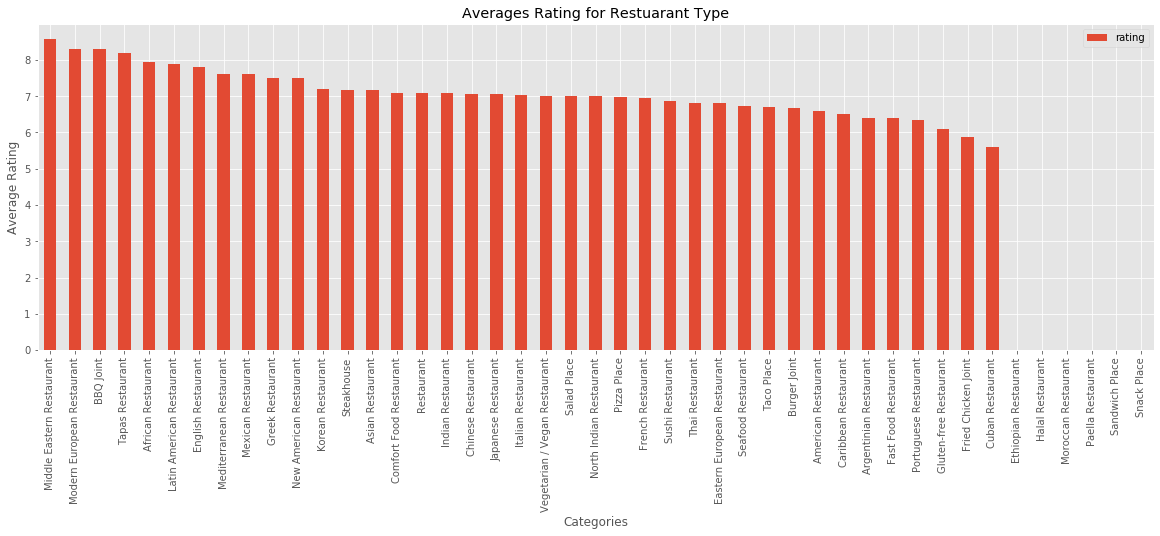

In [88]:
df_graph = df_meanrating

df_graph.sort_values(['rating'], ascending=False, axis=0, inplace=True)

df_graph.plot(kind='bar', figsize=(20, 6))

plt.xlabel('Categories')
plt.ylabel('Average Rating')     
plt.title('Averages Rating for Restuarant Type')

plt.show()

In [89]:
df_ratedfreq = pd.merge(df_meanrating, df_freq, on='categories')
df_ratedfreq['freq'] = df_ratedfreq['freq'].astype(int)/10
df_ratedfreq.sort_values('freq', ascending=False)
df_ratedfreq.head()

,rating,freq
categories,,
Middle Eastern Restaurant,8.566667,0.3
Modern European Restaurant,8.300000,0.1
BBQ Joint,8.300000,0.1
Tapas Restaurant,8.200000,0.2
African Restaurant,7.933333,0.7


In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#df_ratedfreq[['freq']] = scaler.fit_transform(df_ratedfreq[['freq']])

#df_ratedfreq = df_ratedfreq[['freq','rating']]
df_ratedfreq.head()

,rating,freq
categories,,
Middle Eastern Restaurant,8.566667,0.3
Modern European Restaurant,8.300000,0.1
BBQ Joint,8.300000,0.1
Tapas Restaurant,8.200000,0.2
African Restaurant,7.933333,0.7


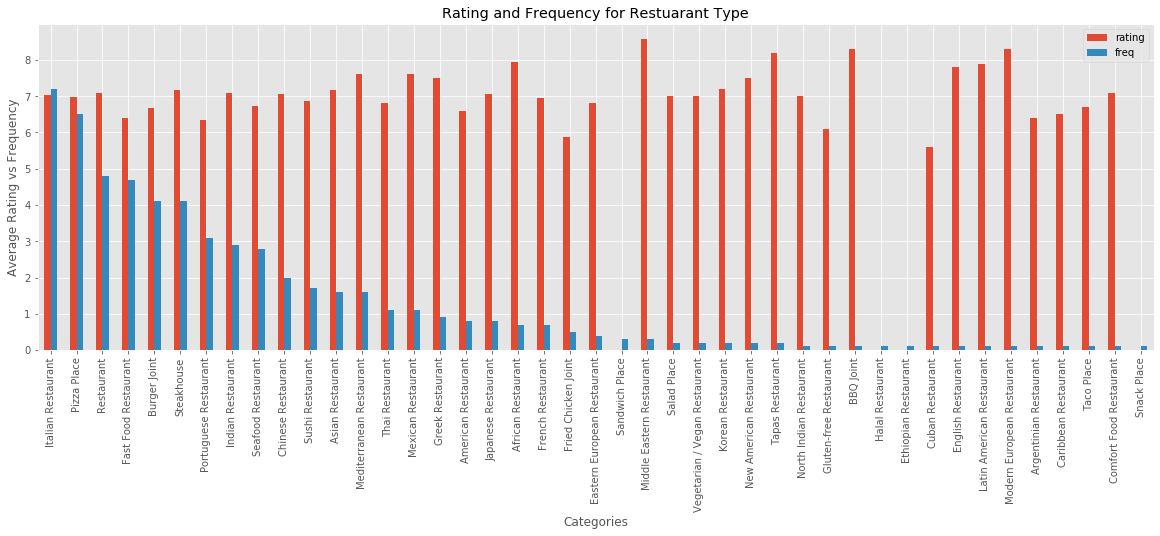

In [91]:
df_graph2 = df_ratedfreq

df_graph2.sort_values(['freq'], ascending=False, axis=0, inplace=True)

df_graph2.plot(kind='bar', figsize=(20, 6))

plt.xlabel('Categories')
plt.ylabel('Average Rating vs Frequency')
plt.title('Rating and Frequency for Restuarant Type')

plt.show()

In [92]:
# one hot encoding
rate_check = pd.get_dummies(df_ratedvenue[['categories']], prefix="", prefix_sep="")

# add categoruy and suburb column back to dataframe
rate_check['categories'] = df_ratedvenue['categories'] 
rate_check['suburb'] = df_ratedvenue['suburb'] 

# arrange columsn
fixed_columns = [rate_check.columns[-1]] + list(rate_check.columns[:-1])
rate_check = rate_check[fixed_columns]

#Group categories by suburb and the sort the rating highest to lowest for each suburb

rate_trangroup = rate_check.groupby(['suburb']).mean().reset_index()
#rate_trangroup.sort_values('rating',ascending=False)

rate_trangroup.head(5)

,suburb,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Burger Joint,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,...,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant
0,Airdlin,0.00,0.0,0.0,0.076923,0.0,0.153846,0.0,0.000000,0.0,...,0.0,0.0,0.076923,0.000000,0.076923,0.000000,0.0,0.0,0.0,0.0
1,Albertskroon,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,Alexandra,0.25,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,Atholl,0.50,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,Benmore,0.00,0.0,0.0,0.142857,0.0,0.000000,0.0,0.047619,0.0,...,0.0,0.0,0.047619,0.047619,0.047619,0.047619,0.0,0.0,0.0,0.0


In [93]:
ven_grouped = rate_trangroup.groupby('suburb').mean().reset_index()
ven_grouped

,suburb,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Burger Joint,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,...,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant
0,Airdlin,0.000000,0.000000,0.0,0.076923,0.000000,0.153846,0.0,0.000000,0.0,...,0.000000,0.0,0.076923,0.000000,0.076923,0.000000,0.0,0.000000,0.000000,0.0
1,Albertskroon,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,Alexandra,0.250000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,Atholl,0.500000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4,Benmore,0.000000,0.000000,0.0,0.142857,0.000000,0.000000,0.0,0.047619,0.0,...,0.000000,0.0,0.047619,0.047619,0.047619,0.047619,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Waverley,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.333333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
100,Wierda Valley,0.029412,0.058824,0.0,0.000000,0.029412,0.029412,0.0,0.029412,0.0,...,0.029412,0.0,0.058824,0.000000,0.088235,0.000000,0.0,0.029412,0.029412,0.0
101,Windsor Glen,0.000000,0.500000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
102,Wynberg,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.500000,0.000000,0.0,0.000000,0.000000,0.0


In [94]:
num_top_venues = 5

for hood in rate_trangroup['suburb']:
    print("----"+hood+"----")
    temp = rate_trangroup[rate_trangroup['suburb'] == hood].T.reset_index()
    temp.columns = ['categories','rating']
    temp = temp.iloc[1:]
    temp['rating'] = temp['rating'].astype(float)
    temp = temp.round({'rating': 2})
    print(temp.sort_values('rating', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Airdlin----
                 categories  rating
0      Fast Food Restaurant    0.15
1              Burger Joint    0.15
2  Mediterranean Restaurant    0.08
3         Indian Restaurant    0.08
4     Portuguese Restaurant    0.08


----Albertskroon----
                  categories  rating
0         Italian Restaurant     1.0
1         African Restaurant     0.0
2      Portuguese Restaurant     0.0
3         Mexican Restaurant     0.0
4  Middle Eastern Restaurant     0.0


----Alexandra----
                  categories  rating
0       Fast Food Restaurant    0.75
1         African Restaurant    0.25
2      Portuguese Restaurant    0.00
3         Mexican Restaurant    0.00
4  Middle Eastern Restaurant    0.00


----Atholl----
                  categories  rating
0         African Restaurant     0.5
1          Indian Restaurant     0.5
2      Portuguese Restaurant     0.0
3         Mexican Restaurant     0.0
4  Middle Eastern Restaurant     0.0


----Benmore----
              categories

In [95]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [103]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['suburb'] = rate_trangroup['suburb']

for ind in np.arange(rate_trangroup.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(rate_trangroup.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Airdlin,Burger Joint,Fast Food Restaurant,Indian Restaurant,Asian Restaurant,Steakhouse
1,Albertskroon,Italian Restaurant,Japanese Restaurant,Indian Restaurant,Halal Restaurant,Greek Restaurant
2,Alexandra,Fast Food Restaurant,African Restaurant,Japanese Restaurant,Indian Restaurant,Halal Restaurant
3,Atholl,African Restaurant,Indian Restaurant,Japanese Restaurant,Halal Restaurant,Greek Restaurant
4,Benmore,Indian Restaurant,Asian Restaurant,Restaurant,Italian Restaurant,Portuguese Restaurant


In [104]:
# Begin identifying best K cluster to use
Kmeanscheck = ven_grouped.drop('suburb', 1)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Kmeanscheck)
    Sum_of_squared_distances.append(km.inertia_)

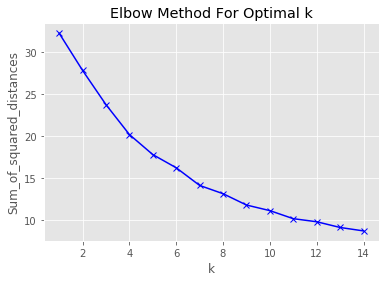

In [105]:
#Plot k Cluster results
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [106]:
#because elbow method failed to produce good results move to silhoutte method
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(Kmeanscheck)
  labels = kmeans.labels_
  sil.append(silhouette_score(Kmeanscheck, labels, metric = 'euclidean'))

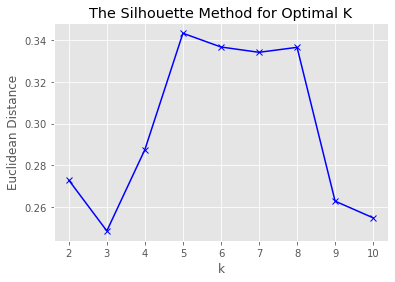

In [107]:
#plot Silhoutees using k range 2-11 (because min range was set at 2)
kmax = range(2,11)
plt.plot(kmax, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Euclidean Distance')
plt.title('The Silhouette Method for Optimal K')
plt.show()

In [34]:
from sklearn.cluster import KMeans

In [108]:
# set number of clusters
kclusters = 8

venue_grouped_clustering = ven_grouped.drop('suburb', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:5] 

array([2, 6, 7, 4, 4], dtype=int32)

In [109]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ven_merged = df_suburb

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ven_merged = ven_merged.join(neighborhoods_venues_sorted.set_index('suburb'), on='suburb')
#venue_grouped_clustering = ven_grouped.drop('suburb', 1)

ven_merged.head() # check the last columns!

,suburb,slat,slong,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Abbotsford,-26.143177,28.068441,NaN,NaN,NaN,NaN,NaN,NaN
1,Airdlin,-26.026461,28.060637,2.0,Burger Joint,Fast Food Restaurant,Indian Restaurant,Asian Restaurant,Steakhouse
2,Albertskroon,-26.161389,27.975000,6.0,Italian Restaurant,Japanese Restaurant,Indian Restaurant,Halal Restaurant,Greek Restaurant
3,Alexandra,-26.104444,28.098889,7.0,Fast Food Restaurant,African Restaurant,Japanese Restaurant,Indian Restaurant,Halal Restaurant
4,Atholhurst,-26.117810,28.070796,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
neighborhoods_venues_sorted.head()

,Cluster Labels,suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,2,Airdlin,Burger Joint,Fast Food Restaurant,Indian Restaurant,Asian Restaurant,Steakhouse
1,6,Albertskroon,Italian Restaurant,Japanese Restaurant,Indian Restaurant,Halal Restaurant,Greek Restaurant
2,7,Alexandra,Fast Food Restaurant,African Restaurant,Japanese Restaurant,Indian Restaurant,Halal Restaurant
3,4,Atholl,African Restaurant,Indian Restaurant,Japanese Restaurant,Halal Restaurant,Greek Restaurant
4,4,Benmore,Indian Restaurant,Asian Restaurant,Restaurant,Italian Restaurant,Portuguese Restaurant


In [111]:
ven_merged.loc[ven_merged['Cluster Labels'] == 0, ven_merged.columns[[0] + list(range(4, ven_merged.shape[1]))]]

,suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
14,Bordeaux,African Restaurant,Japanese Restaurant,Indian Restaurant,Halal Restaurant,Greek Restaurant


In [112]:
ven_merged.loc[ven_merged['Cluster Labels'] == 1, ven_merged.columns[[0] + list(range(4, ven_merged.shape[1]))]]


,suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
16,Bramley,Portuguese Restaurant,Fried Chicken Joint,Italian Restaurant,Argentinian Restaurant,Asian Restaurant
17,Bramley Gardens,Portuguese Restaurant,Fried Chicken Joint,Eastern European Restaurant,Indian Restaurant,Halal Restaurant
24,Cosmo City,Fried Chicken Joint,Vegetarian / Vegan Restaurant,Japanese Restaurant,Indian Restaurant,Halal Restaurant
40,Gresswold,Fried Chicken Joint,Pizza Place,Burger Joint,Seafood Restaurant,Portuguese Restaurant
104,Savoy EST,Portuguese Restaurant,Fried Chicken Joint,Italian Restaurant,Argentinian Restaurant,Asian Restaurant


In [113]:
ven_merged.loc[ven_merged['Cluster Labels'] == 2, ven_merged.columns[[0] + list(range(4, ven_merged.shape[1]))]]

,suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Airdlin,Burger Joint,Fast Food Restaurant,Indian Restaurant,Asian Restaurant,Steakhouse
10,Birdhaven,Pizza Place,Greek Restaurant,Asian Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant
12,Blackheath,Steakhouse,Burger Joint,Portuguese Restaurant,Sandwich Place,Greek Restaurant
19,Bromhof,Pizza Place,Fried Chicken Joint,Burger Joint,Restaurant,Portuguese Restaurant
27,Cresta,American Restaurant,Greek Restaurant,Steakhouse,Seafood Restaurant,Burger Joint
30,Dunkeld,Restaurant,Steakhouse,Pizza Place,Seafood Restaurant,Portuguese Restaurant
39,Greenside,Pizza Place,Indian Restaurant,Vegetarian / Vegan Restaurant,Burger Joint,Chinese Restaurant
41,Greymont,Italian Restaurant,Pizza Place,Burger Joint,Fast Food Restaurant,Indian Restaurant
43,Highlands North,American Restaurant,Indian Restaurant,Seafood Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant
47,Hyde Park,Restaurant,Pizza Place,Greek Restaurant,Asian Restaurant,Steakhouse


In [116]:
ven_merged.loc[ven_merged['Cluster Labels'] ==3, ven_merged.columns[[0] + list(range(4, ven_merged.shape[1]))]]

,suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
29,Darrenwood,Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Indian Restaurant,Halal Restaurant
42,Helling,Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant
52,Kelland,Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Indian Restaurant,Halal Restaurant
63,Meadowhurst,Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Indian Restaurant,Halal Restaurant
73,Northlands,Steakhouse,Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Halal Restaurant
89,Poortview,Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Indian Restaurant,Halal Restaurant
91,Randpark,Fast Food Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Indian Restaurant
111,Sundowner,Pizza Place,Restaurant,Vegetarian / Vegan Restaurant,Halal Restaurant,Greek Restaurant
123,Windsor Glen,American Restaurant,Restaurant,Vegetarian / Vegan Restaurant,English Restaurant,Indian Restaurant


In [117]:
ven_merged.loc[ven_merged['Cluster Labels'] ==4, ven_merged.columns[[0] + list(range(4, ven_merged.shape[1]))]]

,suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Atholl,African Restaurant,Indian Restaurant,Japanese Restaurant,Halal Restaurant,Greek Restaurant
6,Benmore,Indian Restaurant,Asian Restaurant,Restaurant,Italian Restaurant,Portuguese Restaurant
11,Birnam Park,Italian Restaurant,Pizza Place,Burger Joint,Indian Restaurant,Sushi Restaurant
15,Boskruin,Pizza Place,Restaurant,Fried Chicken Joint,Portuguese Restaurant,Italian Restaurant
20,Bryanston,Seafood Restaurant,Restaurant,Pizza Place,French Restaurant,Chinese Restaurant
21,Bryanston Ext,Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Steakhouse
22,Bryanston Shopping Centre,Italian Restaurant,Asian Restaurant,Restaurant,English Restaurant,Indian Restaurant
23,Cheltondale,Italian Restaurant,Sushi Restaurant,Fast Food Restaurant,Indian Restaurant,Ethiopian Restaurant
25,Craigavon,Italian Restaurant,Chinese Restaurant,Seafood Restaurant,Cuban Restaurant,Pizza Place
26,Craighall,Italian Restaurant,Pizza Place,Indian Restaurant,Asian Restaurant,Burger Joint


In [118]:
ven_merged.loc[ven_merged['Cluster Labels'] ==5, ven_merged.columns[[0] + list(range(4, ven_merged.shape[1]))]]

,suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
36,Fairmount,Pizza Place,Vegetarian / Vegan Restaurant,Indian Restaurant,Halal Restaurant,Greek Restaurant
38,Glenhazel,Pizza Place,Vegetarian / Vegan Restaurant,Indian Restaurant,Halal Restaurant,Greek Restaurant
50,Jacanlee,Pizza Place,Vegetarian / Vegan Restaurant,Indian Restaurant,Halal Restaurant,Greek Restaurant
55,Linbro Park,Pizza Place,Vegetarian / Vegan Restaurant,Indian Restaurant,Halal Restaurant,Greek Restaurant
92,Randpark Ridge,Pizza Place,Vegetarian / Vegan Restaurant,Indian Restaurant,Halal Restaurant,Greek Restaurant


In [119]:
ven_merged.loc[ven_merged['Cluster Labels'] ==6, ven_merged.columns[[0] + list(range(4, ven_merged.shape[1]))]]

,suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Albertskroon,Italian Restaurant,Japanese Restaurant,Indian Restaurant,Halal Restaurant,Greek Restaurant
32,Eagle'S Nest,Italian Restaurant,Japanese Restaurant,Indian Restaurant,Halal Restaurant,Greek Restaurant
33,East Town,Italian Restaurant,Japanese Restaurant,Indian Restaurant,Halal Restaurant,Greek Restaurant
48,Illovo,Italian Restaurant,Steakhouse,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,English Restaurant
78,Orange Grove,Italian Restaurant,Japanese Restaurant,Indian Restaurant,Halal Restaurant,Greek Restaurant
119,Waterval EST,Italian Restaurant,Japanese Restaurant,Indian Restaurant,Halal Restaurant,Greek Restaurant


In [120]:
ven_merged.loc[ven_merged['Cluster Labels'] ==7, ven_merged.columns[[0] + list(range(4, ven_merged.shape[1]))]]

,suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Alexandra,Fast Food Restaurant,African Restaurant,Japanese Restaurant,Indian Restaurant,Halal Restaurant
8,Bergvlei,Steakhouse,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Indian Restaurant
13,Bloubosrand,Steakhouse,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Indian Restaurant,Halal Restaurant
62,Marlboro,Steakhouse,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Indian Restaurant,Halal Restaurant
94,Rembrandtpark,Steakhouse,Seafood Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant
125,Wynberg,Steakhouse,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Indian Restaurant
126,Zonneblom,Pizza Place,Steakhouse,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Halal Restaurant


In [121]:
ven_merged.loc[ven_merged['Cluster Labels'] ==8, ven_merged.columns[[0] + list(range(4, ven_merged.shape[1]))]]

,suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
